# Representing Text

Now that we have the data cleaned, we can start to convert the text into a representation that can be used with `sklearn`'s classifiers.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from matplotlib import pyplot as plt
import numpy as np

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
trolls = pd.read_csv("data/trolls.csv")
X, y = (trolls["Comment"], trolls["Insult"])
selection = [33, 34]
print(X[selection])

33    "@sdnoriko LOL as if Capcom listens. Watch the...
34    "Allinit123, your\xa0hypocrisy\xa0is sickening...
Name: Comment, dtype: object


In [3]:
def clean(X):
    # Lowercase everything
    X = X.str.lower()
    
    # Get rid of those duplicate backslashes
    X = X.str.replace(r'\\\\', r'\\', case=False)
    
    # Remove whitespace
    X = X.str.replace('"', ' ')
    X = X.str.replace('_', ' ')
    X = X.str.replace('-', ' ')
    X = X.str.replace(r'\n', ' ')
    X = X.str.replace(r'\\n', ' ')
    X = X.str.replace(r'\t', ' ')
    X = X.str.replace(r'\\t', ' ')
    X = X.str.replace(r"\\xa0", ' ') # A space
    X = X.str.replace(r"\\xc2", ' ') # A space
    X = X.str.replace(' +', ' ')
    
    # Ditch all other unicode
    X = X.str.decode("unicode_escape").str.encode('ascii', 'ignore').str.decode("utf-8")
    
    # Remove contractions
    X = X.str.replace("won't", "will not")
    X = X.str.replace("can't", "can not")
    X = X.str.replace("don't", "do not")
    X = X.str.replace("i'm", "i am")
    X = X.str.replace(" im", " i am")
    X = X.str.replace("ain't", "is not")
    X = X.str.replace("'ll", " will")
    X = X.str.replace("'t", " not")
    X = X.str.replace("'ve", " have")
    X = X.str.replace("'re", " are")
    X = X.str.replace("'d", " would")
    
    # Create tokens of interest
    X = X.str.replace(r"([#%&\*\$]{2,})(\w*)", r"_SW") # Swearword obfuscations
    X = X.str.replace(r" [8x;:=]-?(?:\)|\}|\]|>){2,}", " _BS") # Big smileys
    X = X.str.replace(r" (?:[;:=]-?[\)\}\]d>])|(?:<3)", " _S") # Smileys   
    X = X.str.replace(r" [x:=]-?[\(\[\|\\/\{<]', r", " _F") # Sad faces
    X = X.str.replace(r" [x:=]-?(?:\(|\[|\||\\|/|\{|<){2,}", " _BF") # Big Sad faces   
    X = X.str.replace(r"(@[a-z]+)", r"_AT") # Directed at someone
    X = X.str.replace(r"[\w\-][\w\-\.]+@[\w\-][\w\-\.]+[a-zA-Z]{1,4}", r"_EM") # Email
    X = X.str.replace(r"\w+:\/\/\S+", r"_U") # URL
    
    return X

X = clean(X)

## `CountVectorizer`

The simplest form of transformation is to count the number of times a word is used in a document.

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X[selection])
print(X_train_counts.shape)

(2, 25)


In [5]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display_markdown
    df = df.round(2)
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return ((df_formatted.to_csv(sep="|", index=False)))

print(pandas_df_to_markdown_table(pd.DataFrame(X_train_counts.A, columns=count_vect.get_feature_names())))

_at|allinit123|am|as|capcom|fuck|hope|hypocrisy|if|ignorant|is|listens|lol|loser|love|okami|sickening|them|this|too|up|watch|wrong|you|your
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
1|0|1|1|1|1|1|0|1|0|0|1|1|0|1|1|0|1|1|1|1|1|1|0|0
0|1|0|0|0|0|0|1|0|1|1|0|0|1|0|0|1|0|0|0|0|0|0|1|1



## Stemming

You can see that there are various forms of words in there. Plurals, contractions, tense, etc.

Stemming is the process of removing these lexical extras and replace them with a simple, compound version.

In [6]:
def stemming(X):
    X = X.str.replace("ies( |$|\.)", "y ")  # Plurals
    X = X.str.replace("(?<!i)s( |$|\.)", " ")  # Plurals
    X = X.str.replace("ing( |$|\.)", " ")  # adverbs
    X = X.str.replace("ed( |$|\.)", " ")  # Past tense
    X = X.str.replace("your( |$|\.)", "you ") # Personal
    X = X.str.replace("our( |$|\.)", "us ") # Personal
    return X

X = stemming(X)

In [7]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X[selection])
print(X_train_counts.shape)

(2, 23)


In [8]:
print(pandas_df_to_markdown_table(pd.DataFrame(X_train_counts.A, columns=count_vect.get_feature_names())))

_at|allinit123|am|capcom|fuck|hope|hypocrisy|if|ignorant|is|listen|lol|loser|love|okami|sickening|them|this|too|up|watch|wrong|you
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
1|0|1|1|1|1|0|1|0|0|1|1|0|1|1|0|1|1|1|1|1|1|0
0|1|0|0|0|0|1|0|1|1|0|0|1|0|0|1|0|0|0|0|0|0|2



## Stopwords

Stopwords are words that join sentences and often provide no meaning.

In [9]:
def stopwords(X):
    X = X.str.replace("the( |$)", " ")
    X = X.str.replace("and( |$)", " ")
    X = X.str.replace("but( |$)", " ")
    X = X.str.replace("of( |$)", " ")
    X = X.str.replace("on( |$)", " ")
    return X

X = stopwords(X)

In [10]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X[selection])
print(X_train_counts.shape)
print(pandas_df_to_markdown_table(pd.DataFrame(X_train_counts.A, columns=count_vect.get_feature_names())))

(2, 23)
_at|allinit123|am|capcom|fuck|hope|hypocrisy|if|ignorant|is|listen|lol|loser|love|okami|sickening|them|this|too|up|watch|wrong|you
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
1|0|1|1|1|1|0|1|0|0|1|1|0|1|1|0|1|1|1|1|1|1|0
0|1|0|0|0|0|1|0|1|1|0|0|1|0|0|1|0|0|0|0|0|0|2



# TD-IDF

TDIDF is a measure of information content for each token.

We can select the maximum number of highest value features to return from the algorithm. We're not passing any other parameters because we have already performed the cleaning and the stop words above.

However we're still passing in raw text, so we need split on words (like the `CountVectorizer`).

In [11]:
tfidf_vect = TfidfVectorizer(analyzer = "word", tokenizer=None, preprocessor=None, stop_words=None, max_features=5000)
X_train_counts = tfidf_vect.fit_transform(X[selection])
print(X_train_counts.shape)
print(pandas_df_to_markdown_table(pd.DataFrame(X_train_counts.A, columns=count_vect.get_feature_names())))

(2, 23)
_at|allinit123|am|capcom|fuck|hope|hypocrisy|if|ignorant|is|listen|lol|loser|love|okami|sickening|them|this|too|up|watch|wrong|you
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
0.25|0.0|0.25|0.25|0.25|0.25|0.0|0.25|0.0|0.0|0.25|0.25|0.0|0.25|0.25|0.0|0.25|0.25|0.25|0.25|0.25|0.25|0.0
0.0|0.32|0.0|0.0|0.0|0.0|0.32|0.0|0.32|0.32|0.0|0.0|0.32|0.0|0.0|0.32|0.0|0.0|0.0|0.0|0.0|0.0|0.63



In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
tfidf_vect = TfidfVectorizer(analyzer = "word", tokenizer=None, preprocessor=None, stop_words=None, max_features=500)
X_train_counts = tfidf_vect.fit_transform(X_train)
X_test_counts = tfidf_vect.transform(X_test)
print(X_train_counts.shape)

(3157, 500)


## Classify

Let's now attempt to classify the data

In [14]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=50, random_state=42)
clf.fit(X_train_counts, y_train)
scores = cross_val_score(clf, X_train_counts, y_train)
scores.mean()           

0.8238878116360161

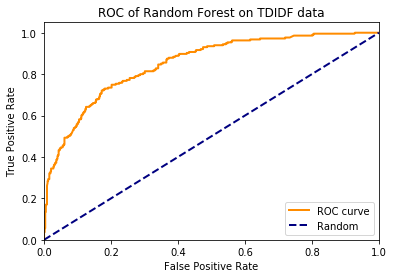

In [15]:
y_proba = clf.predict_proba(X_test_counts)
fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])

plt.figure();
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest on TDIDF data')
plt.legend(loc="lower right")
plt.show()

In [16]:
def lit_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

print(lit_confusion_matrix(y_test, clf.predict(X_test_counts)))

[[ 96  30]
 [119 545]]


In [17]:
print("\n".join(["Troll %s: %s" % (y, x) for x, y in zip(X_test[:2].values, y[:2].values)]))

Troll 1:  you are a mor son.. come  be a man  call it like it is.. 
Troll 0:  how old are you? 


In [18]:
clf.predict_proba(X_test_counts[:2])

array([[ 0.57163829,  0.42836171],
       [ 0.92269122,  0.07730878]])

# Balancing

We saw earlier how important it was to balance the datasets. Here we do that to get a better representation of performance.

In [19]:
def balanced_spl_by(df, lblcol, uspl=True):
    datas_l = [ df[df[lblcol]==l].copy() for l in list(set(df[lblcol].values)) ]
    lsz = [f.shape[0] for f in datas_l ]
    return pd.concat([f.sample(n = (min(lsz) if uspl else max(lsz)), replace = (not uspl)).copy() for f in datas_l ], axis=0 ).sample(frac=1)

In [20]:
trolls = balanced_spl_by(trolls, "Insult")
X, y = (trolls["Comment"], trolls["Insult"])

In [21]:
X = clean(X)
X = stemming(X)
X = stopwords(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
tfidf_vect = TfidfVectorizer(analyzer = "word", tokenizer=None, preprocessor=None, stop_words=None, max_features=500)
X_train_counts = tfidf_vect.fit_transform(X_train)
X_test_counts = tfidf_vect.transform(X_test)
print(X_train_counts.shape)

(1678, 500)


In [23]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=50, random_state=42)
clf.fit(X_train_counts, y_train)
scores = cross_val_score(clf, X_train_counts, y_train)
scores.mean()           

0.73420592251237415

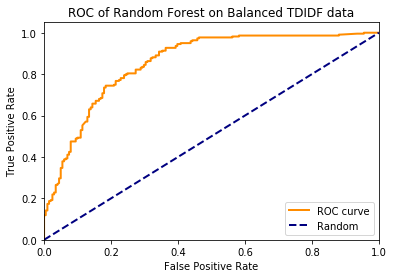

In [24]:
y_proba = clf.predict_proba(X_test_counts)
fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])

plt.figure();
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest on Balanced TDIDF data')
plt.legend(loc="lower right")
plt.show()

In [25]:
print(lit_confusion_matrix(y_test, clf.predict(X_test_counts)))

[[171  47]
 [ 48 154]]


## How far can you go?

You can improve a lot here. You can try different classifiers. You can tune the parameters. You can go back to the text and improve the cleaning/stemming/etc.

Incidentally, whilst writing these notes I found an error with a stemmer that removed ALL `s` from the end of words. E.g. `this` was turned into `thi`. After fixing that, the results shut up by 5%!!!

## Tasks

- Whats the best performance you can get? Who can get the best?